In [1]:
include("UndrivenHelium.jl")
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false, size=(600,600), color=:black, markersize = 0.3 )
const Z = 2.0
const order = 20
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500_000

500000

In [2]:
include("Integ.jl")

taylorintegps (generic function with 1 method)

In [3]:
function undrivenHelium!(τ, q, dq)
    Q₁, Q₂, P₁, P₂ = q
    
    t1 = Q₁^2
    t2 = Q₂^2
    t = t1 * t2
    R12 = t1 - t2
    aR12 = abs(R12)
    RRR = aR12^3
    c1 = R12/RRR
   
    dq[1] = 0.25*t2*P₁
    dq[3] = 2*Q₁*(-0.125*P₂^2 + Z  - t2 - t2/aR12 + t*c1)
    dq[2] = 0.25*t1*P₂
    dq[4] = 2*Q₂*(-0.125*P₁^2 + Z  - t1 - t1/aR12 - t*c1)

#    return [t, q₁, q₂, p₁, p₂] 
    nothing
end

var1 = set_variables("t q1 q2 p1 p2", order = 1)


function condini(x10::Float64, px10::Float64)
    @assert x10 != 0
    Q1 = sqrt(x10)
    Q2 = 0.0
    P1 = px10*sqrt(x10)    
    P2 = sqrt(8Z)    
    return Float64[Q1, Q2, P1, P2]
end

function regHam(t, Q₁, Q₂, P₁, P₂)
    #Cantidades auxiliares
    P₁² = P₁^2
    P₂² = P₂^2
    Q₁² = Q₁^2
    Q₂² = Q₂^2
    nf = abs(Q₁² - Q₂²)
    
    H = 0.125*(P₁²*Q₂² + P₂²*Q₁²) - Z*(Q₁² + Q₂²) + Q₁²*Q₂²*(1.0 + 1.0/nf)
    return H
end


regHam(v) = regHam(v...)

regHam (generic function with 2 methods)

In [4]:
function vareqs_taylorinteg{T<:Number}(f, q0::Array{T,1}, t0::T, tmax::T,
        order::Int, abstol::T; maxsteps::Int=500)
    # Allocation
    const tv = Array{T}(maxsteps+1)
    dof = length(q0)
    const xv = Array{T}(dof, maxsteps+1)
    const jt = eye(T, dof)
    const vT = zeros(T, order+1)
    vT[2] = one(T)

    # NOTE: This changes GLOBALLY internal parameters of TaylorN
    global _δv = set_variables("δ", order=1, numvars=dof)

    # Initial conditions
    @inbounds tv[1] = t0
    for ind in 1:dof
        @inbounds xv[ind,1] = q0[ind]
    end
    const x0 = vcat(q0, reshape(jt, dof*dof))
    nx0 = dof*(dof+1)
    t00 = t0

    # Initialize the vector of Taylor1 expansions
    const x = Array{Taylor1{T}}(nx0)
    for i in eachindex(x0)
        @inbounds x[i] = Taylor1( x0[i], order )
    end

    #Allocate auxiliary arrays
    const dx = Array{Taylor1{T}}(nx0)
    const xaux = Array{Taylor1{T}}(nx0)
    const δx = Array{TaylorN{Taylor1{T}}}(dof)
    const dδx = Array{TaylorN{Taylor1{T}}}(dof)
    const jac = Array{Taylor1{T}}(dof,dof)
    for i in eachindex(jac)
        @inbounds jac[i] = zero(x[1])
    end

    #auxiliary arrays for symplectic structure tests
    const δSv = Array{T}(maxsteps+1); δSv[1] = zero(T)
    auxJn = Int(dof/2)
    const J_n = vcat(  hcat(zeros(auxJn,auxJn), eye(auxJn,auxJn)), hcat(-eye(auxJn,auxJn), zeros(auxJn,auxJn))  )

    # Integration
    nsteps = 1
    while t0 < tmax
        δt = TaylorIntegration.liap_taylorstep!(f, x, dx, xaux, δx, dδx, jac, t0, tmax, x0, order, abstol, vT)
        for ind in eachindex(jt)
            @inbounds jt[ind] = x0[dof+ind]
        end
        t0 += δt
        tspan = t0-t00
        nsteps += 1
        @inbounds tv[nsteps] = t0
        @inbounds for ind in 1:dof
            xv[ind,nsteps] = x0[ind]
        end
        δSv[nsteps] = norm( jt'*J_n*jt-J_n, Inf)
        if nsteps > maxsteps
            warn("""
            Maximum number of integration steps reached; exiting.
            """)
            break
        end
    end

    return view(tv,1:nsteps),  view(transpose(xv),1:nsteps,:),  view(δSv,1:nsteps)
end

vareqs_taylorinteg (generic function with 1 method)

In [5]:
#Initial conditions
c1 = condini1D(5.8008, 0.0)

4-element Array{Float64,1}:
 2.40849
 0.0    
 0.0    
 4.0    

In [6]:
@time t1, x1 = taylorinteg(undrivenHelium1D!, c1, 0.0, 30.0, 25, 1e-20, maxsteps=30000 );  

  0.798140 seconds (1.85 M allocations: 165.639 MiB, 4.81% gc time)


In [7]:
x1

646×4 SubArray{Float64,2,Array{Float64,2},Tuple{UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}:
 2.40849   0.0        0.0           4.0       
 2.40848   0.402178  -0.00305927    3.86299   
 2.40843   0.728654  -0.0174123     3.52292   
 2.40814   0.98353   -0.0394506     3.05424   
 2.40744   1.17535   -0.0586786     2.50155   
 2.4064    1.31122   -0.0654073     1.9017    
 2.4053    1.4002    -0.0558369     1.27905   
 2.40447   1.45047   -0.0320742     0.643888  
 2.40417   1.4668     0.000157396  -0.00373739
 2.40451   1.44849    0.0336889    -0.681299  
 2.40532   1.39833    0.0562282    -1.29604   
 2.40635   1.3152     0.0652751    -1.87949   
 2.40732   1.19522    0.0602748    -2.4285    
 ⋮                                            
 2.40428   1.45283   -0.0297413     0.595727  
 2.40402   1.46664    0.00338748   -0.0631939 
 2.4044    1.44648    0.0354459    -0.717089  
 2.40523   1.39478    0.057254     -1.32768   
 2.40627   1.30978    0.0655538    -1.90968   
 2.

In [8]:
@time tvS, xvS, δSv, mv = vartaylorinteg(undrivenHelium1D!, c1, 0.0, 30.0, 25, 1e-20, maxsteps=30000 );  

  9.484365 seconds (100.89 M allocations: 7.062 GiB, 23.71% gc time)


In [9]:
norm(δSv,Inf)

NaN


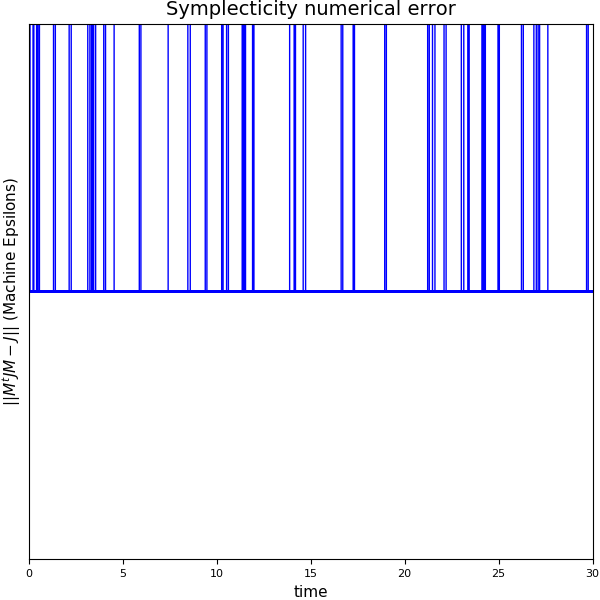

In [10]:
plot(tvS, δSv/eps(), title = "Symplecticity numerical error", color = :blue)
yaxis!(L"$||M^tJM - J||$ (Machine Epsilons)")
xaxis!("time")

In [11]:
xvS

646×4 SubArray{Float64,2,Array{Float64,2},Tuple{UnitRange{Int64},Base.Slice{Base.OneTo{Int64}}},false}:
 2.40849   0.0        0.0           4.0       
 2.40848   0.402178  -0.00305927    3.86299   
 2.40843   0.728654  -0.0174123     3.52292   
 2.40814   0.98353   -0.0394506     3.05424   
 2.40744   1.17535   -0.0586786     2.50155   
 2.4064    1.31122   -0.0654073     1.9017    
 2.4053    1.4002    -0.0558369     1.27905   
 2.40447   1.45047   -0.0320742     0.643888  
 2.40417   1.4668     0.000157396  -0.00373739
 2.40451   1.44849    0.0336889    -0.681299  
 2.40532   1.39833    0.0562282    -1.29604   
 2.40635   1.3152     0.0652751    -1.87949   
 2.40732   1.19522    0.0602748    -2.4285    
 ⋮                                            
 2.40428   1.45283   -0.0297413     0.595727  
 2.40402   1.46664    0.00338748   -0.0631939 
 2.4044    1.44648    0.0354459    -0.717089  
 2.40523   1.39478    0.057254     -1.32768   
 2.40627   1.30978    0.0655538    -1.90968   
 2.